In [1]:
# 导入PySpark
import findspark
findspark.init()#找到并激活Spark
import pyspark
# pyspark.__version__#查看版本信息
# 指定计算机集群位置，链接到本地集群
from pyspark import SparkContext
sc = SparkContext("local", "First App")#生成sc实例，这个和pyspark shell内置sc一样都是local

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('local[*]') \
    .config('first_spark_application') \
    .getOrCreate()

In [3]:
spark

# 第一部分 数据预处理

## 读入并检查数据

In [4]:
# 读取文件构建dataframe
df0 = spark.read.csv("fyc20.csv", header = True, inferSchema = True, nullValue = 'NA')
# 通过行数、列名与列数来检查数据读入是否正确
display(df0.count())#行数
display(len(df0.columns))#列数

27805

1452

## 数据清洗

In [5]:
# 删除无用变量
import pandas as pd
drop_id = pd.read_excel(r"变量簿5.0.xlsx", sheet_name='该删掉的变量',header=None)  ## 读入该删除的变量，包括插补值、重复值和ID等
drop_id = drop_id[0].tolist()
df0 = df0.drop(*(drop_id))
display(df0.count())#行数
display(len(df0.columns))#列数

## 对y做处理
df0 = df0.filter((df0['CVDLAYCA53']>0) |(df0['CVDLAYDN53']>0) | (df0['CVDLAYPM53']>0)) # 只保留COVID_DELAY >0的行
df0 = df0.withColumn("CVDLAY",((df0['CVDLAYCA53']==1) |(df0['CVDLAYDN53']==1) | (df0['CVDLAYPM53']==1)).cast("int")) ##3个covid相关列合成新列
df0 = df0.drop(*['CVDLAYCA53','CVDLAYDN53','CVDLAYPM53'])# 删除旧列
display(df0.count())#行数
display(len(df0.columns))#列数

27805

1347

27443

1345

In [6]:
# 同义变量只保留最近期调查值
drop_list = []
i = 0
while i <= (len(df0.columns)-4):
    #首先判断变量名中是否有‘31’
    if df0.columns[i].count('31') >= 1:
        #print("31")
        fol_str = df0.columns[i+1]+df0.columns[i+2]+df0.columns[i+3]
        #判断是否是串联项出现，若有则只保留20项，并从20项后继续扫描
        if df0.columns[i+3].count('20') >= 1:
            #print("31+20")
            drop_list.append(df0.columns[i])
            drop_list.append(df0.columns[i+1])
            drop_list.append(df0.columns[i+2])
            i+=4
        elif df0.columns[i+2].count('53') >= 1:
            #print("31+53")
            drop_list.append(df0.columns[i])
            drop_list.append(df0.columns[i+1])
            i+=3 
        #其余的情况，若无串联，若后续变量中有较晚时期出现，则删掉此变量
        elif (fol_str.count('20')+fol_str.count('53')+fol_str.count('42')) >= 1:
            #print("31+")
            drop_list.append(df0.columns[i])
            i+=1
        else:
            i+=1
        continue
    elif df0.columns[i].count('42') >= 1:
        #print("42")
        fol_str = df0.columns[i+1]+df0.columns[i+2]
        if (fol_str.count('20')+fol_str.count('53')) >= 1:
            drop_list.append(df0.columns[i])
            i+=1
        else:
            i+=1
        continue
    elif df0.columns[i].count('53') >= 1: 
        #print("53")
        if (df0.columns[i+1].count('20')) >= 1:
            drop_list.append(df0.columns[i])
            i+=1
        else:
            i+=1
        continue
    # 若是插补标志点，则删去
    elif df0.columns[i].count('IMP') >= 1:
            drop_list.append(df0.columns[i])
            i+=1
    else:
        #print("not-deleted")
        i+=1 

In [7]:
df = df0.drop(*drop_list)
display(len(df.columns))#列数

1052


## 缺失值处理


In [8]:
# 求每一列异常值（负值）的数量
import pyspark.sql.functions as sql
na_num = df.select([sql.count(sql.when((df[c]<0),c)).alias(c) 
            for c in df.columns])
na_num = na_num.toPandas()

In [9]:
#删除异常值占比超过50%的列
thre = round(df.count()*0.5,0) # 取删除阈值
drop_list = []
for i in df.columns:
    if na_num[i][0]>=thre:
        #print(i)
        drop_list.append(i)

df = df.drop(*drop_list)
display(len(df.columns))#列数

844

In [10]:
for i in df.columns:
    df = df.withColumn(i, sql.col(i)*df.PERWT20F)  # 乘上个人权重
    df = df.withColumn(i, sql.when(sql.col(i)<0,0).otherwise(sql.col(i)))# 把负值（缺失）补成0

# 第二部分 可视化

In [11]:
# 载入R包
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter #引用包中的百分比函数
from numpy.random import randn
from matplotlib.pyplot import plot,savefig
import numpy
%matplotlib inline
import seaborn as sb
import pandas as pd

## 准备可视化相关数据

In [12]:
# 抽取可视化部分特征
vis_features = ['AGELAST', 'SEX', 'EDUCYR', 'UNINS20', 'TOTTCH20', 'OBTOTV20', 'CVDLAY']
visdf = df.select(vis_features)
visdf = visdf.filter(visdf['EDUCYR']>0)
# 对数据进行采样，并转换到Pandas中
sampledf = visdf.sample(False, 0.2, 2022)
vis_pd = sampledf.toPandas()

In [13]:
# 根据绘图效果对部分列向量做对数处理
vis_pd['logTOTTCH20'] = numpy.log(vis_pd['TOTTCH20']+1)
vis_pd['logOBTOTV20'] = numpy.log(vis_pd['OBTOTV20']+1)

In [14]:
# 数据概览
vis_pd.describe()

,AGELAST,SEX,EDUCYR,UNINS20,TOTTCH20,OBTOTV20,CVDLAY,logTOTTCH20,logOBTOTV20
count,4741.000000,4741.000000,4741.000000,4741.000000,4.741000e+03,4741.000000,4741.000000,4741.000000,4741.000000
mean,45.179709,1.535541,12.291078,1.916473,1.285431e+04,6.003164,0.312170,6.467194,1.250117
std,21.337675,0.498788,3.946700,0.276706,4.315013e+04,12.120309,0.463428,3.570334,1.105941
min,6.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1.000000,11.000000,2.000000,2.020000e+02,0.000000,0.000000,5.313206,0.000000
50%,45.000000,2.000000,12.000000,2.000000,1.569000e+03,2.000000,0.000000,7.358831,1.098612
75%,63.000000,2.000000,16.000000,2.000000,7.344000e+03,6.000000,1.000000,8.901775,1.945910
max,85.000000,2.000000,17.000000,2.000000,1.250572e+06,294.000000,1.000000,14.039112,5.686975


## 受访者信息

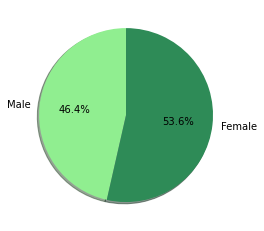

In [15]:
# 性别
plt.pie([2202, 2539],
        labels=['Male', 'Female'],
        shadow=True,startangle=90,# explode=[0.05, 0.1], 
        autopct='%1.1f%%', colors=['lightgreen', 'seagreen'])
plt.savefig('饼图-性别.png', dpi=300, bbox_inches='tight')
plt.show()

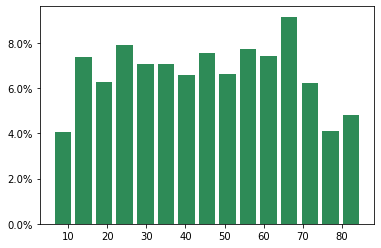

In [16]:
# 年龄
def to_percent(y,position):
    return str(100*y)+"%"#这里可以用round（）函数设置取几位小数
x=vis_pd['AGELAST']
plt.hist(x,bins=15,rwidth=0.8, color=["seagreen"], weights=[1./len(x)]*len(x))#这里weights是每一个数据的权重，这里设置是1，weights是和x等维的列表或者series
fomatter=FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(fomatter)
plt.savefig('直方图-年龄分布.png', dpi=300, bbox_inches='tight')
plt.show()

## 离散变量

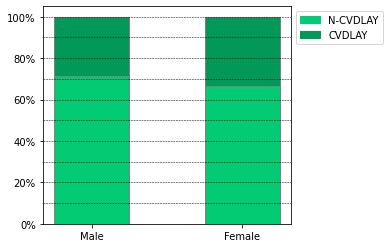

In [17]:
# 性别
import numpy as np
import pandas as pd
colors = ['#02CB74','#019858']
labels = ['Male', 'Female']
y1 = [1574, 1687]
y2 = [628, 852]
data = [y1, y2]

x = range(len(labels)) #将获取的labels依次给到x轴

bottom_y = np.zeros(len(labels)) #将bottom_y元素都初始化为0
data = np.array(data) #将data放入数组中
sums = np.sum(data, axis=0) #求数组data的和，为计算百分比做准备

j = 0
 
figure, ax = plt.subplots() #创建子图，默认设置
for i in data: #通过函数进行绘制图像
    y = i / sums #获取各个y值的百分比
    plt.bar(x, y, width=0.5, color=np.array(colors)[j], bottom=bottom_y, edgecolor='gray')
    bottom_y = y + bottom_y #实现百分比柱状条的堆积
    plt.xticks(x, labels) #设置x轴的坐标标签
    legend_labels = ['N-CVDLAY', 'CVDLAY']  #设置图像图例
    color = ['#02CB74','#019858'] #给定与柱状条相同的颜色
    #将颜色和图例标签对应起来
    patches = [mpatches.Patch(color=color[h],label="{:s}".format(legend_labels[h])) for h in range(len(legend_labels))]
    ax = plt.gca()#绘制子图
    box = ax.get_position()
 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #纵轴设置为百分比
 
    #生成legend，显示标签；用bbox_to_anchor=(1, 1)设置图例的位置
    ax.legend(handles=patches,ncol=1, bbox_to_anchor=(1, 1))  
    figure.subplots_adjust(right=0.7)
    j+=1 #color=np.array(colors)[j],通过数组给定柱状条相应的颜色
 
for i in range(1, 11, 1):#绘制平行于x轴的虚线
    plt.axhline(y=i/10, linestyle='dashed', color='black', linewidth=0.5)
 
labels = ax.get_xticklabels() + ax.get_yticklabels()
 
ax.set_title('',fontsize=13)
ax.set_ylabel('',fontsize=13)
ax.set_xlabel('',fontsize=13)
#plt.rc('font', size=16)
plt.savefig('百分柱状图-性别vsDLAY.png', dpi=300, bbox_inches='tight')
plt.show()

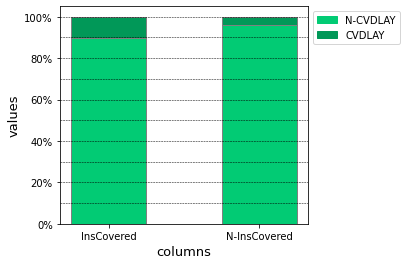

In [18]:
# 是否投保
colors = ['#02CB74','#019858']
labels = ['InsCovered', 'N-InsCovered']
y1 = [2923, 1422]
y2 = [338, 58]
data = [y1, y2]

x = range(len(labels)) #将获取的labels依次给到x轴

bottom_y = np.zeros(len(labels)) #将bottom_y元素都初始化为0
data = np.array(data) #将data放入数组中
sums = np.sum(data, axis=0) #求数组data的和，为计算百分比做准备

j = 0
 
figure, ax = plt.subplots() #创建子图，默认设置
for i in data: #通过函数进行绘制图像
    y = i / sums #获取各个y值的百分比
    plt.bar(x, y, width=0.5, color=np.array(colors)[j], bottom=bottom_y, edgecolor='gray')
    bottom_y = y + bottom_y #实现百分比柱状条的堆积
    plt.xticks(x, labels) #设置x轴的坐标标签
    legend_labels = ['N-CVDLAY', 'CVDLAY']  #设置图像图例
    color = ['#02CB74','#019858'] #给定与柱状条相同的颜色
    #将颜色和图例标签对应起来
    patches = [mpatches.Patch(color=color[h],label="{:s}".format(legend_labels[h])) for h in range(len(legend_labels))]
    ax = plt.gca()#绘制子图
    box = ax.get_position()
 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #纵轴设置为百分比
 
    #生成legend，显示标签；用bbox_to_anchor=(1, 1)设置图例的位置
    ax.legend(handles=patches,ncol=1, bbox_to_anchor=(1, 1))  
    figure.subplots_adjust(right=0.7)
    j+=1 #color=np.array(colors)[j],通过数组给定柱状条相应的颜色
 
for i in range(1, 11, 1):#绘制平行于x轴的虚线
    plt.axhline(y=i/10, linestyle='dashed', color='black', linewidth=0.5)
 
labels = ax.get_xticklabels() + ax.get_yticklabels()
 
ax.set_title('',fontsize=13)
ax.set_ylabel('values',fontsize=13)
ax.set_xlabel('columns',fontsize=13)
#plt.rc('font', size=16)
plt.savefig('百分柱状图-保险覆盖vsDLAY.png', dpi=300, bbox_inches='tight')
plt.show()

## 连续变量

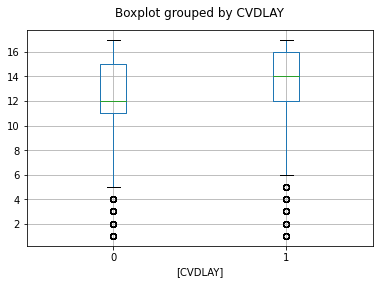

In [19]:
# 教育年限
edudf = vis_pd[['EDUCYR', 'CVDLAY']]
edudf.boxplot(by='CVDLAY')
plt.title('')
plt.rc('font', size=12)
plt.savefig('箱线图-教育年限vsDLAY.png', dpi=300, bbox_inches='tight') # 解决图片不清晰，不完整的问题
plt.show()

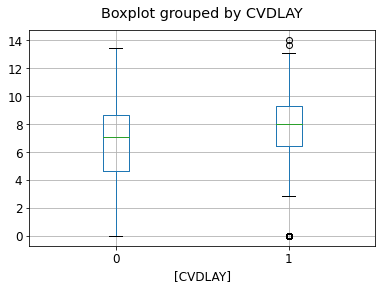

In [20]:
# log医疗费用
chdf = vis_pd[['logTOTTCH20', 'CVDLAY']]
chdf.boxplot(by='CVDLAY')
plt.title('')
plt.rc('font', size=12)
plt.savefig('箱线图-log医疗费用vsDLAY.png', dpi=300, bbox_inches='tight') # 解决图片不清晰，不完整的问题
plt.show()

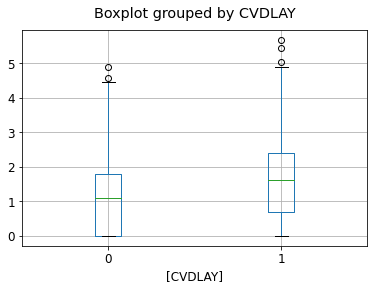

In [21]:
# log医院访问次数
obdf = vis_pd[['logOBTOTV20', 'CVDLAY']]
obdf.boxplot(by='CVDLAY')
plt.title('')
plt.rc('font', size=12)
plt.savefig('箱线图-log医院访问次数vsDLAY.png', dpi=300, bbox_inches='tight')
plt.show()

# 第三部分 全变量建模

In [19]:
class DataFrameProcessor:
    def __init__(self, file_path):
        try:
            self.df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error loading data: {e}")

    def select_features(self):
        #用于分开数字变量和分类变量，并删除CVCLAY列防止标签泄露
        try:
            cat_features = [item[0] for item in self.df.dtypes.items() if item[1]=='object']
            num_features = [item[0] for item in self.df.dtypes.items() if item[1]!='object']
            num_features.remove('CVDLAY')
            return cat_features, num_features
        except Exception as e:
            print(f"Error selecting features: {e}")
            return [], []  # Return empty lists in case of an exception


In [7]:
processor = DataFrameProcessor("output.csv")

In [11]:
cat_features, num_features = processor.select_features()

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [13]:
stages = []
for col in cat_features:
    # 字符串转成索引
    string_index = StringIndexer(inputCol = col, outputCol = col + 'Index')
    # 转换为OneHot编码
    encoder = OneHotEncoder(inputCols=[string_index.getOutputCol()], outputCols=[col + "_one_hot"])
    # 将每个字段的转换方式 放到stages中
    stages += [string_index, encoder]

In [14]:
# 将CVDLAY转换为索引
label_string_index = StringIndexer(inputCol = 'CVDLAY', outputCol = 'label')
# 添加到stages中
stages += [label_string_index]

In [15]:
# 类别变量 + 数值变量
assembler_cols = [c + "_one_hot" for c in cat_features] + num_features
assembler = VectorAssembler(inputCols=assembler_cols, outputCol="features")
stages += [assembler]

In [16]:
# 使用pipeline完成数据处理
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
selected_cols = ["label", "features"] + cols
df = df.select(selected_cols)

In [29]:
import pandas as pd
pd.DataFrame(df.take(20), columns = df.columns)

,label,features,_c0,PANEL,FAMID20,FAMIDYR,CPSFAMID,RULETR20,RUSIZE20,RUCLAS20,...,RXVA20,RXTRI20,RXOFD20,RXSTL20,RXWCP20,RXOSR20,RXPTR20,RXOTH20,PERWT20F,CVDLAY
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,23,A,A,A,A,2,1,...,0,0,0,0,0,0,0,0,8418.417067,0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2,23,A,A,A,A,2,1,...,0,0,0,0,0,0,0,0,5199.931866,0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",3,23,A,A,A,A,2,1,...,0,0,0,0,0,0,0,0,2139.840017,0
3,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4,23,B,B,B,B,1,1,...,0,0,0,0,0,0,0,0,2216.008686,0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5,23,A,A,A,A,2,1,...,0,0,0,0,0,0,0,0,4157.285889,0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",6,23,A,A,A,A,1,1,...,0,0,0,0,0,0,0,0,1960.941227,0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",7,23,A,A,A,A,1,1,...,0,0,0,0,0,0,0,0,8040.129847,0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",8,23,A,A,A,A,3,1,...,0,0,0,0,0,0,0,0,2605.042054,0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",9,23,A,A,A,A,3,1,...,0,0,0,0,0,0,0,0,7893.029599,0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",10,23,A,A,A,A,3,1,...,0,0,0,0,0,0,0,0,5508.081668,0


In [17]:
train, test = df.randomSplit([0.8, 0.2], seed=2021)
print(train.count())
print(test.count())

22008
5435


## 逻辑回归

In [17]:
from pyspark.ml.classification import LogisticRegression

In [18]:
%%time
# 创建模型
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',maxIter=10)
lr_model = lr.fit(train)


CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 1min 24s


In [19]:
#结果预测
predictions = lr_model.transform(test)

In [20]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.307452


In [21]:
#技术AUC值
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# 模型评估，通过原始数据 rawPrediction计算AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('AUC：', evaluator.evaluate(predictions))

AUC： 0.822154945255841


In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 创建网格参数，用于交叉验证
param_grid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
# 三折交叉验证，设置模型，网格参数，验证方法，折数
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# 交叉验证运行
cv_model = cv.fit(train)
# 对于测试数据，使用三折交叉验证
predictions = cv_model.transform(test)
print('AUC：', evaluator.evaluate(predictions))

AUC： 0.822154945255841


## 决策树

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier

In [19]:
%%time
# 创建决策树模型
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt_model = dt.fit(train)
predictions = dt_model.transform(test)

CPU times: user 124 ms, sys: 24 ms, total: 148 ms
Wall time: 1min 50s


In [20]:
#查看决策树结构
print(dt_model._call_java('toDebugString'))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_54aeb1a084b1, depth=3, numNodes=7, numClasses=2, numFeatures=16820
  If (feature 16541 <= 1.5)
   Predict: 0.0
  Else (feature 16541 > 1.5)
   If (feature 16026 <= 15.5)
    Predict: 0.0
   Else (feature 16026 > 15.5)
    If (feature 16541 <= 5.5)
     Predict: 0.0
    Else (feature 16541 > 5.5)
     Predict: 1.0



In [21]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.102116


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#计算AUC值
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.4748477893199358

In [24]:
#网格调参
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             #.addGrid(dt.maxBins, [20, 40, 80])
             .build())
# 设置三折交叉验证
cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# 运行cv
cv_model = cv.fit(train)
# 查看最优模型
#print("numNodes = ", cv_model.bestModel.numNodes)
print("depth = ", cv_model.bestModel.depth)

depth =  6


In [25]:
# 使用三折交叉验证进行预测
predictions = cv_model.transform(test)
evaluator.evaluate(predictions)

0.48896989031387156

## 随机森林

In [26]:
from pyspark.ml.classification import RandomForestClassifier

In [27]:
%%time
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train)
predictions = rf_model.transform(test)


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 2min 27s


In [28]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.0


In [29]:
#计算AUC值
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.6354740457779029

In [ ]:
param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5, 7])
             .addGrid(rf.maxBins, [20, 50])
             .addGrid(rf.numTrees, [5, 10])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = cv.fit(train)
predictions = cv_model.transform(test)
evaluator.evaluate(predictions)

# 第三部分 选变量建模

In [35]:
cols = df.columns
#找到所有的string类型的变量
#dtypes用来看数据变量类型
cat_features = [item[0] for item in df.dtypes if item[1]=='string']
#找到所有数字变量
num_features = [item[0] for item in df.dtypes if item[1]!='string']
num_features.remove('CVDLAY')
# 需要删除 CVDLAY列，否则标签泄露

In [36]:
choose_features = ['EDUCYR', 'ADPCFL42', 'ADENGY42', 'ADNERV42', 'K6SUM42', 'ADSLEEP42', 'ADNERV42', 'K6SUM42', 'ADSLEEP42', 'UNINS20', 
            'TOTTCH20', 'TOTEXP20', 'TOTSLF20', 'TOTPRV20', 'TOTPTR20', 'OBTOTV20', 'OBVTCH20', 'OBVEXP20', 'OBVSLF20', 
            'OBVPRV20', 'OBVPTR20', 'OBDRV20', 'OBDTCH20', 'OBDEXP20', 'OBDSLF20', 'OBDPRV20', 'OBDPTR20', 'OPTOTV20', 'OPTTCH20', 
            'OPTEXP20', 'OPFTCH20', 'OPFEXP20', 'OTHTCH20', 'OTHEXP20', 'OTHSLF20', 'RXTOT20', 'RXEXP20', 'RXSLF20', 'RXPRV20', 
            'RXPTR20', 'AGELAST' , 'SEX', 'RACETHX', 'INSCOV20']

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [38]:
stages = []
for col in cat_features:
    # 字符串转成索引
    string_index = StringIndexer(inputCol = col, outputCol = col + 'Index')
    # 转换为OneHot编码
    encoder = OneHotEncoder(inputCols=[string_index.getOutputCol()], outputCols=[col + "_one_hot"])
    # 将每个字段的转换方式 放到stages中
    stages += [string_index, encoder]

In [39]:
# 将CVDLAY转换为索引
label_string_index = StringIndexer(inputCol = 'CVDLAY', outputCol = 'label')
# 添加到stages中
stages += [label_string_index]

In [40]:
# 类别变量 + 数值变量
assembler_cols = choose_features
assembler = VectorAssembler(inputCols=assembler_cols, outputCol="features")
stages += [assembler]

In [32]:
drop_list = ['label','features']
df = df.drop(*drop_list)
#df.printSchema()

In [42]:
# 使用pipeline完成数据处理
pipeline1 = Pipeline(stages=stages)
pipeline_model1 = pipeline1.fit(df)
df = pipeline_model1.transform(df)
selected_cols1 = ["label", "features"] + cols
df = df.select(selected_cols1)

In [43]:
train, test = df.randomSplit([0.8, 0.2], seed=2021)
print(train.count())
print(test.count())

22008
5435


## 逻辑回归

In [45]:
from pyspark.ml.classification import LogisticRegression

In [46]:
%%time
# 创建模型
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',maxIter=10)
lr_model = lr.fit(train)


CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 19.9 s


In [47]:
#结果预测
predictions = lr_model.transform(test)

In [48]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.030175


In [49]:
#技术AUC值
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# 模型评估，通过原始数据 rawPrediction计算AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('AUC：', evaluator.evaluate(predictions))

AUC： 0.6198187510030135


In [51]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 创建网格参数，用于交叉验证
param_grid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
# 三折交叉验证，设置模型，网格参数，验证方法，折数
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# 交叉验证运行
cv_model = cv.fit(train)
# 对于测试数据，使用三折交叉验证
predictions = cv_model.transform(test)
print('AUC：', evaluator.evaluate(predictions))

AUC： 0.6187750593671902


## 决策树

In [52]:
from pyspark.ml.classification import DecisionTreeClassifier

In [53]:
%%time
# 创建决策树模型
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt_model = dt.fit(train)
predictions = dt_model.transform(test)

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 26.7 s


In [54]:
#查看决策树结构
print(dt_model._call_java('toDebugString'))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fd58ac546657, depth=3, numNodes=7, numClasses=2, numFeatures=44
  If (feature 15 <= 1.5)
   Predict: 0.0
  Else (feature 15 > 1.5)
   If (feature 0 <= 13.5)
    Predict: 0.0
   Else (feature 0 > 13.5)
    If (feature 4 <= 1.5)
     Predict: 0.0
    Else (feature 4 > 1.5)
     Predict: 1.0



In [55]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.102484


In [56]:
#计算AUC值
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.39523832540973175

In [57]:
#网格调参
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             #.addGrid(dt.maxBins, [20, 40, 80])
             .build())
# 设置三折交叉验证
cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# 运行cv
cv_model = cv.fit(train)
# 查看最优模型
print("numNodes = ", cv_model.bestModel.numNodes)
print("depth = ", cv_model.bestModel.depth)

numNodes =  1
depth =  0


In [58]:
# 使用三折交叉验证进行预测
predictions = cv_model.transform(test)
evaluator.evaluate(predictions)

0.5

## 随机森林

In [59]:
from pyspark.ml.classification import RandomForestClassifier

In [60]:
%%time
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train)
predictions = rf_model.transform(test)


CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 31.1 s


In [61]:
#抽取所需信息
selected = predictions.select("label", "prediction", "probability", "CVDLAY")
pred = predictions.select('prediction')
sum_pos = pred.groupBy().sum().toPandas()## 预测得到的延迟医疗的人数
sum_pos/pred.count()  ## 输出预测得到的延迟医疗的人的比例


,sum(prediction)
0,0.007544


In [62]:
#计算AUC值
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.6382344645881849

In [ ]:
param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5, 7])
             .addGrid(rf.maxBins, [20, 50])
             .addGrid(rf.numTrees, [5, 10])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = cv.fit(train)
predictions = cv_model.transform(test)
evaluator.evaluate(predictions)